In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
# read Datos_tratados.csv to a DataFrame
df = pd.read_csv('../Data/Datos_tratados.csv')
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday
0,1,2020-06-09,9,0,192.0,1,0
1,1,2020-06-10,21,0,459.0,1,0
2,1,2020-06-11,15,0,438.0,1,0
3,1,2020-06-12,0,1,423.0,0,1
4,1,2020-06-13,24,1,423.0,1,0


In [3]:
# idSecuencia to date
df['idSecuencia'] = pd.to_datetime(df['idSecuencia'], format='%Y-%m-%d')

# add month and year columns
df['month'] = pd.DatetimeIndex(df['idSecuencia']).month
df['year'] = pd.DatetimeIndex(df['idSecuencia']).year

# add week of the year column, and day of the year column
df['week'] = pd.DatetimeIndex(df['idSecuencia']).week
df['day_of_year'] = pd.DatetimeIndex(df['idSecuencia']).dayofyear

# add quarter column
df['quarter'] = pd.DatetimeIndex(df['idSecuencia']).quarter

df.head()

C:\Users\96gar\AppData\Local\Temp\ipykernel_5784\141523002.py:9: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week'] = pd.DatetimeIndex(df['idSecuencia']).week


,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,day_of_year,quarter
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,161,2
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,162,2
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,163,2
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,164,2
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,165,2


In [4]:
# get all the rows where bolOpen is equal to bolHoliday
df[df['bolOpen'] == df['bolHoliday']]

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,day_of_year,quarter
67,1,2020-08-15,0,1,147.0,1,1,8,2020,33,228,3
125,1,2020-10-12,3,1,162.0,1,1,10,2020,42,286,4
173,1,2020-11-29,0,0,312.0,1,1,11,2020,48,334,4
182,1,2020-12-08,0,0,234.0,1,1,12,2020,50,343,4
208,1,2021-01-03,0,1,261.0,1,1,1,2021,53,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
31484,49,2022-01-02,6,0,138.0,1,1,1,2022,52,2,1
31491,49,2022-01-09,0,0,105.0,1,1,1,2022,1,9,1
31540,49,2022-02-27,3,0,117.0,1,1,2,2022,8,58,1
31623,50,2020-08-15,6,1,93.0,1,1,8,2020,33,228,3


In [5]:
# add season column
def season(row):
    # if is leap year
    leap = 0
    if row['year'] % 4 == 0:
        leap = 1
    spring = range(80 + leap, 172 + leap)
    summer = range(172 + leap, 264 + leap)
    autumn = range(264 + leap, 355 + leap)

    if row['day_of_year'] in spring:
        return 'spring'
    elif row['day_of_year'] in summer:
        return 'summer'
    elif row['day_of_year'] in autumn:
        return 'autumn'
    else:
        return 'winter'

df['season'] = df.apply(season, axis=1)
df.head()


,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,day_of_year,quarter,season
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,161,2,spring
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,162,2,spring
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,163,2,spring
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,164,2,spring
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,165,2,spring


In [6]:
# get the first and last year of the dataset
first_year = df['year'].min()
last_year = df['year'].max()

# create a DataFrame with all the days between the first and last year
df_days = pd.DataFrame(pd.date_range(start=str(first_year) + '-01-01', end=str(last_year) + '-12-31'), columns=['idSecuencia'])

# extract yearmonth column
df_days['yearmonth'] = df_days['idSecuencia'].dt.strftime('%Y%m')
df_days['day_of_week'] = pd.DatetimeIndex(df_days['idSecuencia']).dayofweek
df_days['week'] = pd.DatetimeIndex(df_days['idSecuencia']).week
df_days['year'] = pd.DatetimeIndex(df_days['idSecuencia']).year

# concatenate year and week columns
df_days['yearweek'] = df_days['year'].astype(str) + df_days['week'].astype(str)

# iterate over the yearmonth column
for yearmonth in df_days['yearmonth'].unique():
    # get the first day_of_week=4 of the yearmonth
    first_thursday = df_days[(df_days['yearmonth'] == yearmonth) & (df_days['day_of_week'] == 4)]['idSecuencia'].min()
    # app a column with te first thursday of the yearmonth as a flag
    df_days.loc[df_days['idSecuencia'] == first_thursday, 'first_thursday'] = 1

# get a list of the year and week of the first thursday
first_week_of_month = df_days[df_days['first_thursday'] == 1][['year','week']].values.tolist()

# concatenate the year and week of the list first_thursdays
first_week_of_month = [str(year) + str(week) for year, week in first_week_of_month]

# create a flag at df_days if the yearweek is in the list first_week_of_month
df_days['first_week_of_month'] = df_days['yearweek'].isin(first_week_of_month)

C:\Users\96gar\AppData\Local\Temp\ipykernel_5784\977276921.py:11: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_days['week'] = pd.DatetimeIndex(df_days['idSecuencia']).week


In [7]:
df_first_thursday = df_days[['year','week','yearweek','first_thursday']]
df_first_thursday = df_first_thursday.groupby(['year','week','yearweek'])['first_thursday'].max().reset_index()
df_first_thursday.head()

,year,week,yearweek,first_thursday
0,2020,1,20201,1.0
1,2020,2,20202,NaN
2,2020,3,20203,NaN
3,2020,4,20204,NaN
4,2020,5,20205,NaN


In [8]:
# iterate over the yearweek column
week=1
for yearweek in df_first_thursday['yearweek'].unique():
    # get the row of the yearweek
    row = df_first_thursday[df_first_thursday['yearweek'] == yearweek]
    if row['first_thursday'].values[0] == 1:
        week = 2
    else:
        # add the week to the df_first_thursday
        df_first_thursday.loc[df_first_thursday['yearweek'] == yearweek, 'first_thursday'] = week
        week += 1

df_first_thursday.head()

,year,week,yearweek,first_thursday
0,2020,1,20201,1.0
1,2020,2,20202,2.0
2,2020,3,20203,3.0
3,2020,4,20204,4.0
4,2020,5,20205,5.0


In [9]:
# transform the df_first_thursday first_thursday column to int and rename it to week_of_month
df_first_thursday['first_thursday'] = df_first_thursday['first_thursday'].astype(int)
df_first_thursday.rename(columns={'first_thursday':'week_of_month'}, inplace=True)

df_first_thursday.head()

,year,week,yearweek,week_of_month
0,2020,1,20201,1
1,2020,2,20202,2
2,2020,3,20203,3
3,2020,4,20204,4
4,2020,5,20205,5


In [10]:
# merge df_days with df_first_thursday
df_days = pd.merge(df_days, df_first_thursday, on=['year','week','yearweek'], how='left')
df_days.head()

,idSecuencia,yearmonth,day_of_week,week,year,yearweek,first_thursday,first_week_of_month,week_of_month
0,2020-01-01,202001,2,1,2020,20201,NaN,True,1
1,2020-01-02,202001,3,1,2020,20201,NaN,True,1
2,2020-01-03,202001,4,1,2020,20201,1.0,True,1
3,2020-01-04,202001,5,1,2020,20201,NaN,True,1
4,2020-01-05,202001,6,1,2020,20201,NaN,True,1


In [11]:
# merge df with df_days week_of_month
df = pd.merge(df, df_days[['idSecuencia','week_of_month','day_of_week']], on='idSecuencia', how='left')
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,day_of_year,quarter,season,week_of_month,day_of_week
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,161,2,spring,2,1
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,162,2,spring,2,2
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,163,2,spring,2,3
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,164,2,spring,2,4
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,165,2,spring,2,5


In [12]:
# create a column anmed first_week_of_month with 1 if the week_of_month is 1
df['first_week_of_month'] = df['week_of_month'].apply(lambda x: 1 if x == 1 else 0)
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,day_of_year,quarter,season,week_of_month,day_of_week,first_week_of_month
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,161,2,spring,2,1,0
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,162,2,spring,2,2,0
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,163,2,spring,2,3,0
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,164,2,spring,2,4,0
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,165,2,spring,2,5,0


In [13]:
# binarize columns
df = pd.get_dummies(df, columns=['season'])
df = pd.get_dummies(df, columns=['day_of_week'])
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,season_spring,season_summer,season_winter,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,...,1,0,0,0,1,0,0,0,0,0
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,...,1,0,0,0,0,1,0,0,0,0
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,...,1,0,0,0,0,0,1,0,0,0
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,...,1,0,0,0,0,0,0,1,0,0
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,...,1,0,0,0,0,0,0,0,1,0


Si sabemos el país o región de los datos:
- Calendario de festivos oficiales del país.
- Vacaciones escolares.
- Predicción meteorológica.
- Horas de sol esperadas en el día.
- Eventos especiales del país o región o momento: navidad, black friday, san valentín, san jordi, mundial de fútbol, final champions, olimpiadas.
- Bit: horario de invierno/verano (cambio de hora)

In [14]:
# read Datos_tratados.csv to a DataFrame
df_fest = pd.read_csv('../Data/festivos_nacionales.csv', sep=';')
df_fest.head()

,Dia,Dia_semana,laborable / festivo / domingo festivo,Tipo de Festivo,Festividad
0,01/01/2013,martes,festivo,Festivo nacional,Año Nuevo
1,02/01/2013,miercoles,laborable,NaN,NaN
2,03/01/2013,jueves,laborable,NaN,NaN
3,04/01/2013,viernes,laborable,NaN,NaN
4,05/01/2013,sabado,sabado,NaN,NaN


In [15]:
# dia column has a date in formt dd/mm/yyyy, so we need to transform it to yyyy-mm-dd, and then to datetime
df_fest['Dia'] = pd.to_datetime(df_fest['Dia'].str.replace('/','-'), format='%d-%m-%Y')

# rename Dia column to idSecuencia
df_fest.rename(columns={'Dia':'idSecuencia'}, inplace=True)

df_fest.head()

,idSecuencia,Dia_semana,laborable / festivo / domingo festivo,Tipo de Festivo,Festividad
0,2013-01-01,martes,festivo,Festivo nacional,Año Nuevo
1,2013-01-02,miercoles,laborable,NaN,NaN
2,2013-01-03,jueves,laborable,NaN,NaN
3,2013-01-04,viernes,laborable,NaN,NaN
4,2013-01-05,sabado,sabado,NaN,NaN


In [16]:
# distinct Tipo de Festivo
df_fest['Tipo de Festivo'].unique()

array(['Festivo nacional', nan, 'Festivo de la Comunidad de Madrid',
       'Festivo de la comunidad de Madrid',
       'Festivo local de la ciudad de Madrid',
       'Fiesta Comunidad de Madrid', 'Fiesta nacional', 'Fiesta local',
       'traslado de la Fiesta de la Comunidad de Madrid',
       'Fiesta de la Comunidad de Madrid', 'Festivo local'], dtype=object)

In [17]:
# filter Tipo de Festivo == Festivo nacional or Fiesta nacional
df_fest_nacional = df_fest[(df_fest['Tipo de Festivo'] == 'Festivo nacional') | (df_fest['Tipo de Festivo'] == 'Fiesta nacional')]

# add a columns named flag with 1
df_fest_nacional['Festivo nacional'] = 1

df_fest_nacional.head()

C:\Users\96gar\AppData\Local\Temp\ipykernel_5784\2440276123.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fest_nacional['Festivo nacional'] = 1


,idSecuencia,Dia_semana,laborable / festivo / domingo festivo,Tipo de Festivo,Festividad,Festivo nacional
0,2013-01-01,martes,festivo,Festivo nacional,Año Nuevo,1
6,2013-01-07,lunes,festivo,Festivo nacional,Traslado Epifania del Señor,1
87,2013-03-29,viernes,festivo,Festivo nacional,Viernes Santo,1
120,2013-05-01,miercoles,festivo,Festivo nacional,Fiesta del Trabajo,1
226,2013-08-15,jueves,festivo,Festivo nacional,Asuncion de la Virgen,1


In [18]:
# join df with df_fest_nacional
df = pd.merge(df, df_fest_nacional[['idSecuencia','Festivo nacional']], on='idSecuencia', how='left')
df['Festivo nacional'].fillna(0, inplace=True)
df['Festivo nacional'] = df['Festivo nacional'].astype(int)
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,season_summer,season_winter,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,Festivo nacional
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,...,0,0,0,1,0,0,0,0,0,0
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,...,0,0,0,0,1,0,0,0,0,0
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,...,0,0,0,0,0,1,0,0,0,0
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,...,0,0,0,0,0,0,1,0,0,0
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,...,0,0,0,0,0,0,0,1,0,0


In [19]:
# lag of day before, for each sku of udsVenta
for i in range(1, 8):
    df['udsVenta_lag_' + str(i)] = df.groupby('idSku')['udsVenta'].shift(i)
    df['udsVenta_diff_' + str(i)] = df.groupby('idSku')['udsVenta'].transform(lambda x: x.diff(i))
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,udsVenta_lag_3,udsVenta_diff_3,udsVenta_lag_4,udsVenta_diff_4,udsVenta_lag_5,udsVenta_diff_5,udsVenta_lag_6,udsVenta_diff_6,udsVenta_lag_7,udsVenta_diff_7
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,...,9.0,-9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,...,21.0,3.0,9.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# iterate over idSku and idSecuencia
for idSku in df['idSku'].unique():
    for idSecuencia in df[df['idSku'] == idSku]['idSecuencia'].unique():
        # get the date of the idSecuencia at a year before
        date = pd.to_datetime(idSecuencia) - pd.DateOffset(years=1)
        # get the row of the date
        v = df[(df['idSku'] == idSku) & (df['idSecuencia'] == date)]['udsVenta']

        # if the row exists, add the value to the column udsVenta_lag_365
        if len(v) > 0:
            df.loc[(df['idSku'] == idSku) & (df['idSecuencia'] == idSecuencia), 'udsVenta_lag_365'] = v.values[0]

In [21]:
df

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,udsVenta_diff_3,udsVenta_lag_4,udsVenta_diff_4,udsVenta_lag_5,udsVenta_diff_5,udsVenta_lag_6,udsVenta_diff_6,udsVenta_lag_7,udsVenta_diff_7,udsVenta_lag_365
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,...,-9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,...,3.0,9.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32195,50,2022-03-10,3,0,93.0,1,0,3,2022,10,...,0.0,0.0,3.0,9.0,-6.0,12.0,-9.0,6.0,-3.0,15.0
32196,50,2022-03-11,0,0,90.0,1,0,3,2022,10,...,-3.0,3.0,-3.0,0.0,0.0,9.0,-9.0,12.0,-12.0,3.0
32197,50,2022-03-12,9,0,90.0,1,0,3,2022,10,...,-6.0,3.0,6.0,3.0,6.0,0.0,9.0,9.0,0.0,0.0
32198,50,2022-03-13,0,0,81.0,0,1,3,2022,10,...,-3.0,15.0,-15.0,3.0,-3.0,3.0,-3.0,0.0,0.0,6.0


In [22]:
periods = [2, 4, 8]
operations = ['sum', 'max', 'min', 'mean', 'median', 'std']

# add rolling operations of udsVenta for each sku
for p in periods:
    for op in operations:
        df['udsVenta_rolling_' + op + '_' + str(p)] = df.groupby('idSku')['udsVenta'].transform(lambda x: x.rolling(p).agg(op))
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,udsVenta_rolling_min_4,udsVenta_rolling_mean_4,udsVenta_rolling_median_4,udsVenta_rolling_std_4,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_min_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_std_8
0,1,2020-06-09,9,0,192.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-06-10,21,0,459.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-06-11,15,0,438.0,1,0,6,2020,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-06-12,0,1,423.0,0,1,6,2020,24,...,0.0,11.25,12.0,8.958236,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2020-06-13,24,1,423.0,1,0,6,2020,24,...,0.0,15.00,18.0,10.677078,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# delte the null values of udsVenta_rolling_std_8
df = df[~df['udsVenta_rolling_std_8'].isnull()]
df.head()

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,udsVenta_rolling_min_4,udsVenta_rolling_mean_4,udsVenta_rolling_median_4,udsVenta_rolling_std_4,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_min_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_std_8
7,1,2020-06-16,9,1,369.0,1,0,6,2020,25,...,0.0,15.75,16.5,13.720423,108.0,30.0,0.0,13.500,12.0,10.993505
8,1,2020-06-17,3,1,360.0,1,0,6,2020,25,...,0.0,10.50,6.0,13.527749,102.0,30.0,0.0,12.750,12.0,11.535659
9,1,2020-06-18,33,1,357.0,1,0,6,2020,25,...,3.0,18.75,19.5,14.974979,114.0,33.0,0.0,14.250,12.0,13.392429
10,1,2020-06-19,21,1,324.0,1,0,6,2020,25,...,3.0,16.50,15.0,13.304135,120.0,33.0,0.0,15.000,15.0,13.606721
11,1,2020-06-20,15,1,300.0,1,0,6,2020,25,...,3.0,18.00,18.0,12.489996,135.0,33.0,0.0,16.875,18.0,12.205824


C:\Users\96gar\AppData\Local\Temp\ipykernel_5784\2898868664.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')


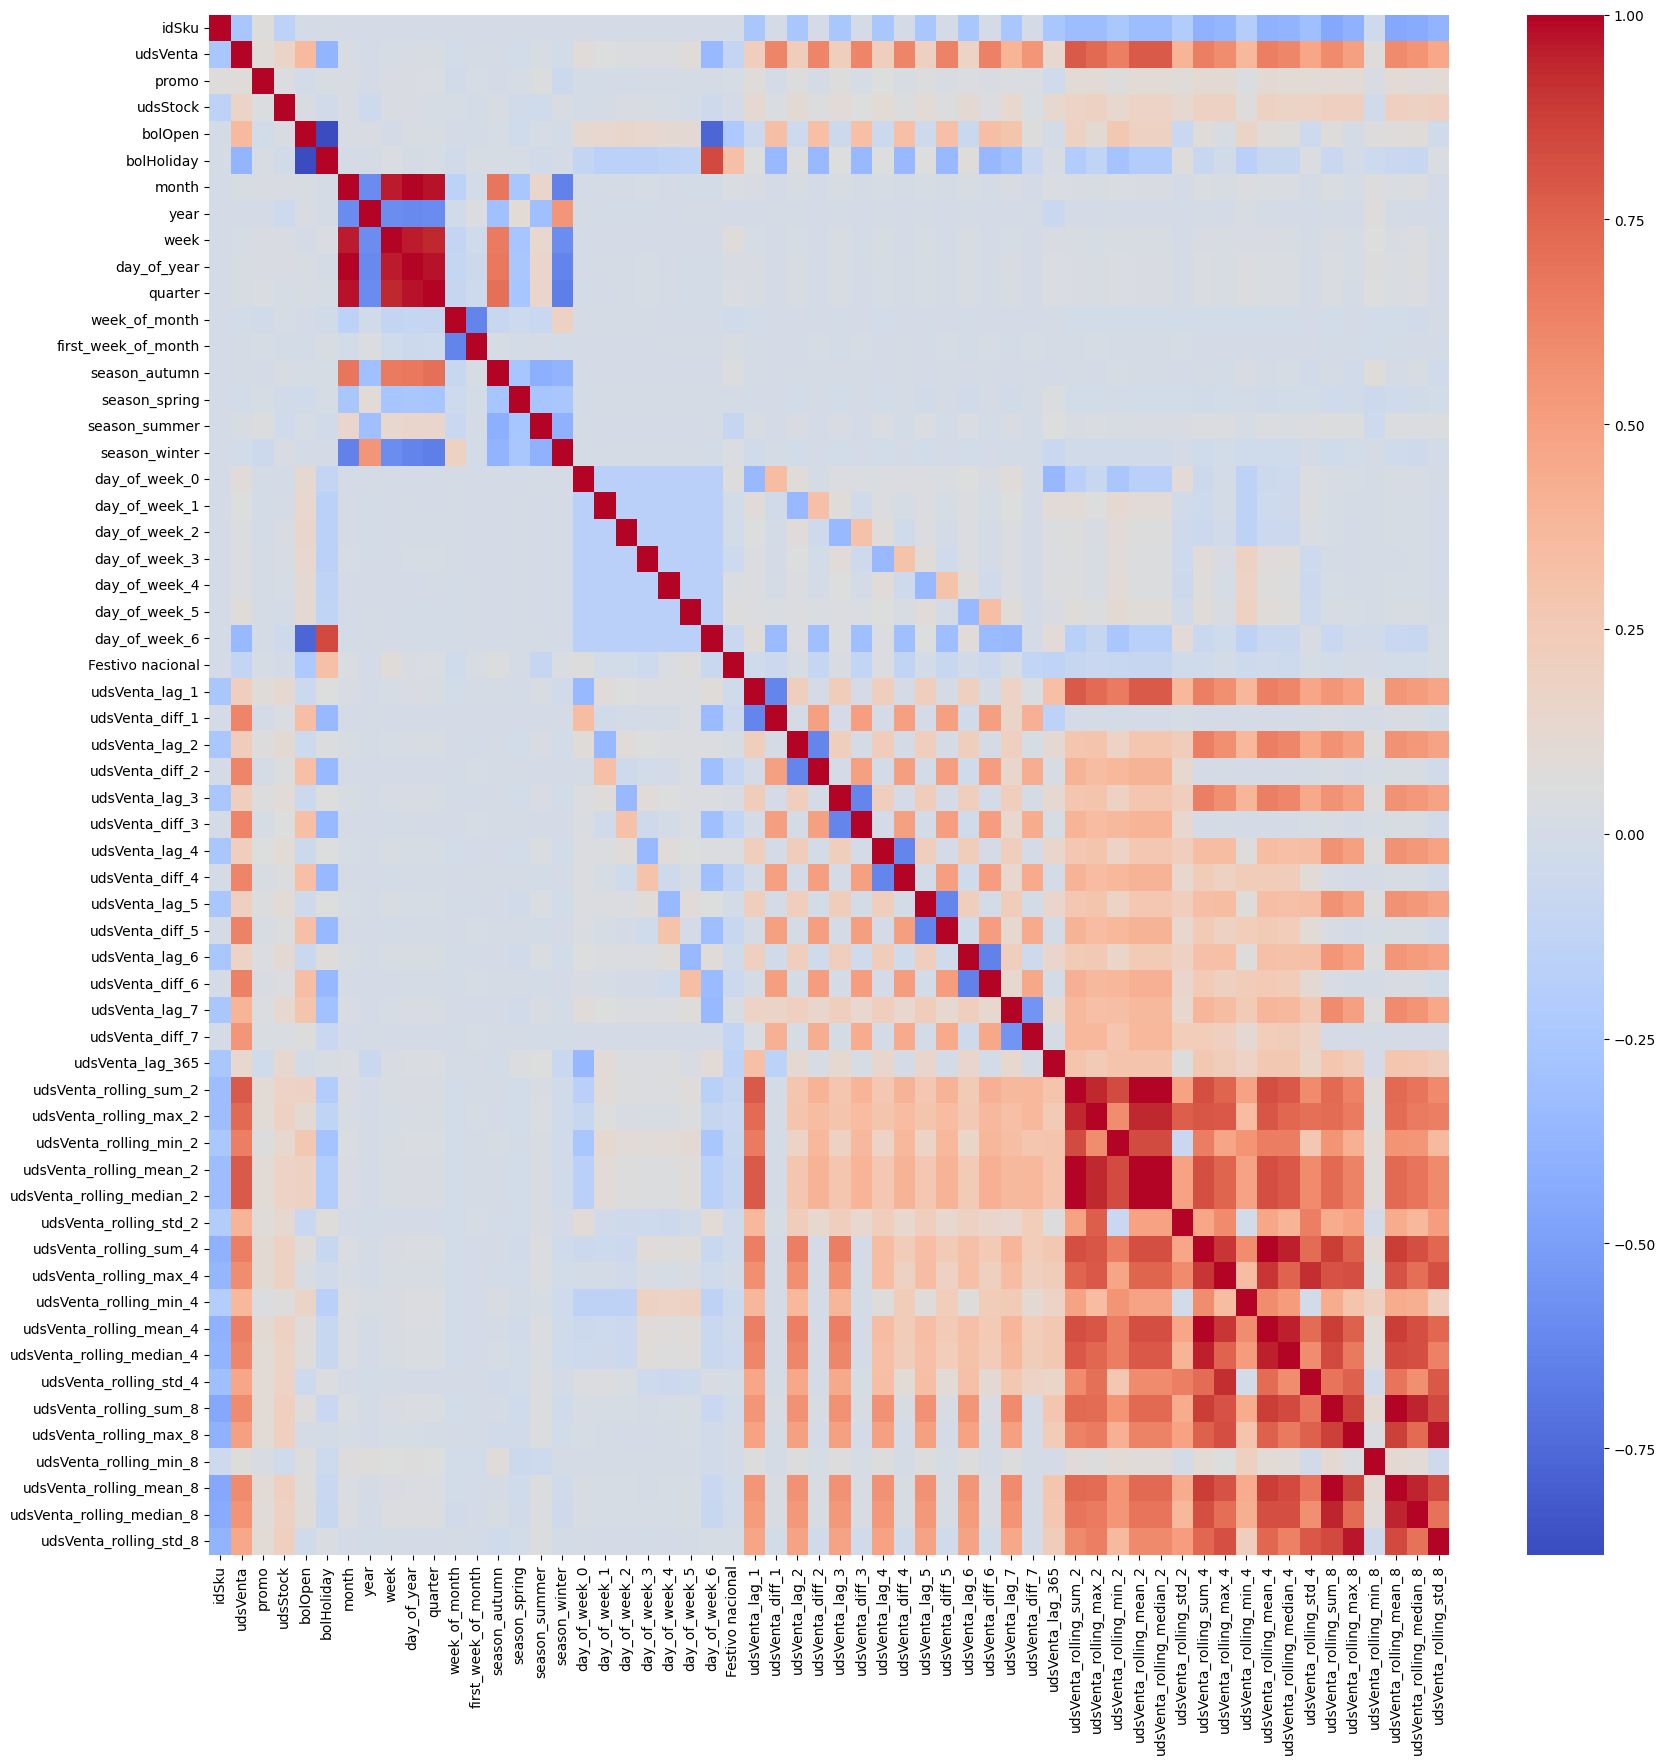

In [24]:
# heatmap of the correlation between the columns
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.show()

C:\Users\96gar\AppData\Local\Temp\ipykernel_5784\3603485053.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr()[['udsVenta']].sort_values(by='udsVenta', ascending=False), annot=True, cmap='coolwarm')


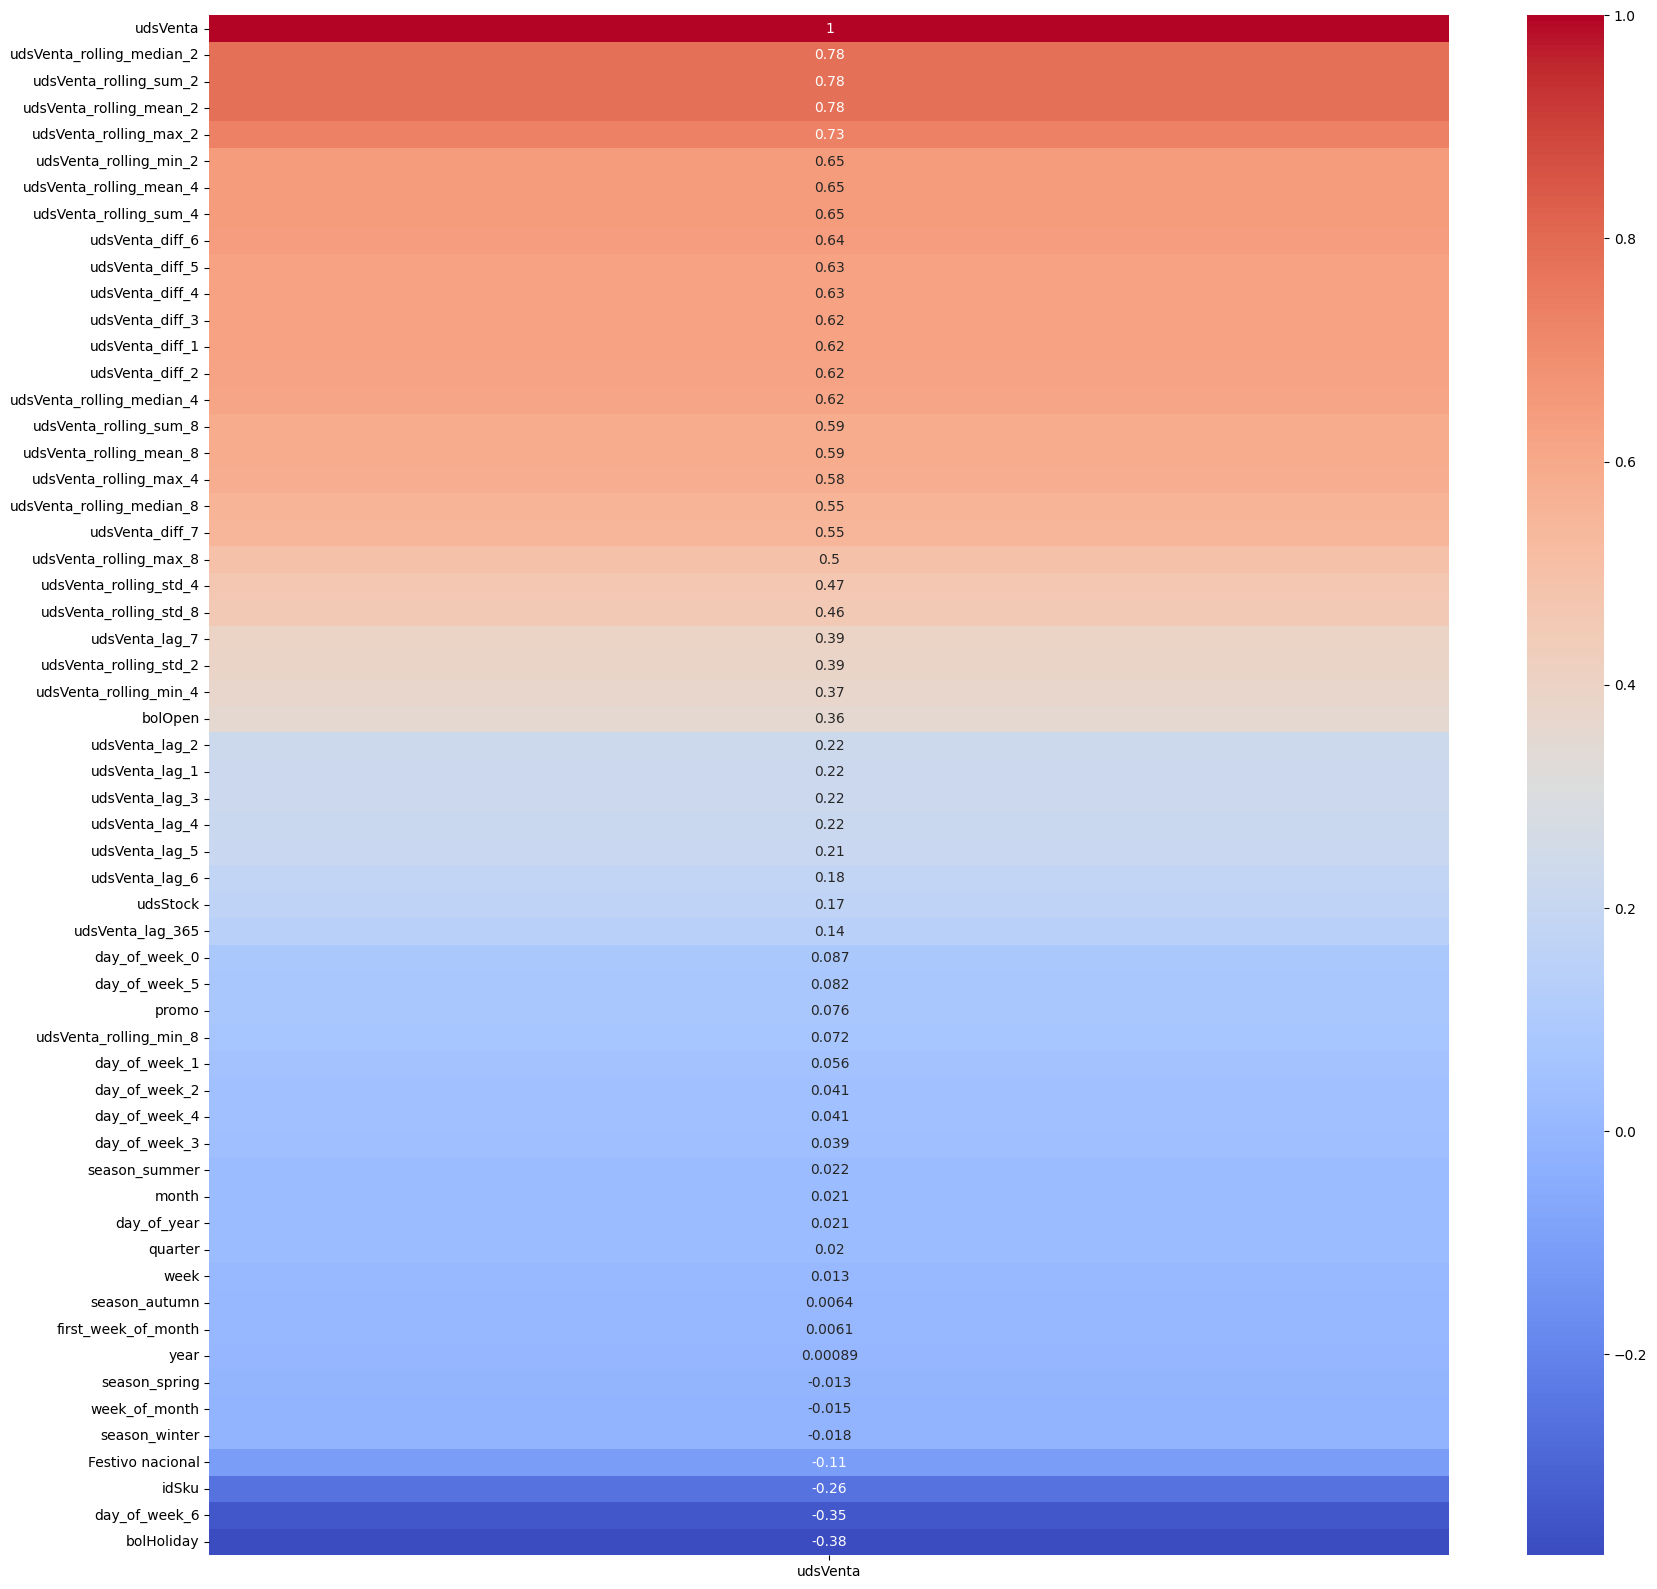

In [25]:
# heatmap of the correlation between udsVenta and the rest of columns
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr()[['udsVenta']].sort_values(by='udsVenta', ascending=False), annot=True, cmap='coolwarm')
plt.show()

In [26]:
# get the correlation coefficients of udsVenta with the rest of columns, for each sku
df_corr = df.groupby('idSku').corr()['udsVenta'].reset_index()

#rename the column level_1 to variable and the column udsVenta to correlation_coefficient
df_corr = df_corr.rename(columns={'level_1': 'variable', 'udsVenta': 'correlation_coefficient'})

# select distinct variable with absolute value of correlation_coefficient > 0.3
corr_variables = df_corr[(df_corr['correlation_coefficient'].abs() > 0.3) & (df_corr['variable'] != 'udsVenta')]['variable'].unique().tolist()
print(corr_variables)

['bolOpen', 'bolHoliday', 'day_of_week_6', 'udsVenta_diff_1', 'udsVenta_diff_2', 'udsVenta_diff_3', 'udsVenta_diff_4', 'udsVenta_diff_5', 'udsVenta_diff_6', 'udsVenta_lag_7', 'udsVenta_diff_7', 'udsVenta_rolling_sum_2', 'udsVenta_rolling_max_2', 'udsVenta_rolling_min_2', 'udsVenta_rolling_mean_2', 'udsVenta_rolling_median_2', 'udsVenta_rolling_sum_4', 'udsVenta_rolling_max_4', 'udsVenta_rolling_mean_4', 'udsVenta_rolling_median_4', 'udsVenta_rolling_sum_8', 'udsVenta_rolling_max_8', 'udsVenta_rolling_mean_8', 'udsVenta_rolling_median_8', 'udsVenta_rolling_min_4', 'udsVenta_rolling_std_4', 'udsVenta_rolling_std_8', 'udsVenta_rolling_std_2', 'promo', 'udsVenta_rolling_min_8']


C:\Users\96gar\AppData\Local\Temp\ipykernel_5784\3062383567.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.corr is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_corr = df.groupby('idSku').corr()['udsVenta'].reset_index()


In [27]:
# create a copy of the dataset
df_norm = df.copy()

In [28]:
# normalize udsvVenta with MinMaxScaler for each sku in df_norm, and create a list with the scaler
for sku in df_norm['idSku'].unique():
    scaler = MinMaxScaler()
    df_norm.loc[df_norm['idSku'] == sku, 'udsVenta'] = scaler.fit_transform(df_norm.loc[df_norm['idSku'] == sku, 'udsVenta'].values.reshape(-1, 1))

df_norm

,idSku,idSecuencia,udsVenta,promo,udsStock,bolOpen,bolHoliday,month,year,week,...,udsVenta_rolling_min_4,udsVenta_rolling_mean_4,udsVenta_rolling_median_4,udsVenta_rolling_std_4,udsVenta_rolling_sum_8,udsVenta_rolling_max_8,udsVenta_rolling_min_8,udsVenta_rolling_mean_8,udsVenta_rolling_median_8,udsVenta_rolling_std_8
7,1,2020-06-16,0.214286,1,369.0,1,0,6,2020,25,...,0.0,15.75,16.5,13.720423,108.0,30.0,0.0,13.500,12.0,10.993505
8,1,2020-06-17,0.071429,1,360.0,1,0,6,2020,25,...,0.0,10.50,6.0,13.527749,102.0,30.0,0.0,12.750,12.0,11.535659
9,1,2020-06-18,0.785714,1,357.0,1,0,6,2020,25,...,3.0,18.75,19.5,14.974979,114.0,33.0,0.0,14.250,12.0,13.392429
10,1,2020-06-19,0.500000,1,324.0,1,0,6,2020,25,...,3.0,16.50,15.0,13.304135,120.0,33.0,0.0,15.000,15.0,13.606721
11,1,2020-06-20,0.357143,1,300.0,1,0,6,2020,25,...,3.0,18.00,18.0,12.489996,135.0,33.0,0.0,16.875,18.0,12.205824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32195,50,2022-03-10,0.200000,0,93.0,1,0,3,2022,10,...,3.0,6.00,3.0,6.000000,51.0,15.0,0.0,6.375,4.5,5.180665
32196,50,2022-03-11,0.000000,0,90.0,1,0,3,2022,10,...,0.0,5.25,3.0,6.652067,45.0,15.0,0.0,5.625,3.0,5.655276
32197,50,2022-03-12,0.600000,0,90.0,1,0,3,2022,10,...,0.0,6.75,6.0,6.652067,42.0,15.0,0.0,5.250,3.0,5.257647
32198,50,2022-03-13,0.000000,0,81.0,0,1,3,2022,10,...,0.0,3.00,1.5,4.242641,33.0,15.0,0.0,4.125,3.0,5.303301


In [29]:
# get the last 20% distinct dates of the dataset
dates = df_norm['idSecuencia'].unique()

dates_train = dates[:int(len(dates)*0.8)]
dates_test = dates[int(len(dates)*0.8):]

# split the dataset in train and test
df_train = df[df['idSecuencia'].isin(dates_train)]
df_test = df[df['idSecuencia'].isin(dates_test)]

In [30]:
# Save the datasets in csv format

df.to_csv('../Data/Datos_enriquecidos.csv', index=False)
df_norm.to_csv('../Data/Datos_enriquecidos_norm.csv', index=False)

df_train.to_csv('../Data/train.csv', index=False)
df_test.to_csv('../Data/test.csv', index=False)